# MSC Datamart - Canadian Precipitation Analysis (CaPA) example

The Canadian Precipitation Analysis (CaPA) is a near real-time analysis of recent accumulated precipitation from Environment and Climate Change Canada (ECCC).

<img src="rdpa-vs-hrdpa-BC.jpg" alt="Comparison of regional 10 kilometer resolution and high 2.5 km resolution versions of the Canadian Precipitation Analysis (CaPA) systems during a British Columbia precipitation event" title="RDPA versus HRDPA systems"/>

## Requirements

Data can be downloaded from Datamart using standard Python libraries.

In [1]:
import os
import requests
import tempfile
from datetime import datetime, date, time, timedelta

CaPA data is disseminated through Datamart in grib2 format. 

It's relatively easy to work with grib2 files in Python using the third-party library [xarray](http://xarray.pydata.org/en/stable/index.html "xarray documentation"), but first, make sure xarray is installed in your Python environment. This can be done with [Conda](https://conda.io "Conda documentation").

Or alternatively with [pip](https://pypi.org/project/pip/ "Pip Documentation").

Additionally, the xarray [documentation](https://xarray.pydata.org/en/stable/user-guide/io.html#grib-format-via-cfgrib "xarray cfgrib") notes that you will need to install the [cfgrib](https://pypi.org/project/cfgrib/ "cfgrib documentation") interface to enable the `engine='cfgrib'`.  This can be done using the same procedure with either conda or pip.

Once installed, xarray can be imported (there's no need to import cfgrib here, so long as it is installed xarray will have access to it).

In [2]:
import xarray as xr

This example will also demonstrate plotting functionality using third-party libraries, including [Matplotlib](https://matplotlib.org/ "Matplotlib documentation") and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/ "Cartopy documentation").  If you haven't done so already, these libraries will also need to first be installed in your Python environment using the same methodology as described above for xarray.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cf

## Accessing the data

CaPA data is available through [Datamart](https://dd.weather.gc.ca/analysis/precip/).  

In [4]:
datamart = 'https://dd.weather.gc.ca/'

### 10-km and 2.5 km versions of CaPA

There are currently two different versions of CaPA available: 

1) Regional Deterministic Precipitation Analysis (RDPA), which has a resolution of 10 km and covers most of North America
2) High Resolution Deterministic Precipitation Analysis (HRDPA) system, which has a resolution of 2.5 km and covers most of Canada plus some transoundary areas of the United States.

<img src="rdpa-vs-hrdpa-global.jpg" alt="Comparison of spatial domains of the regional 10 kilometer resolution and high 2.5 km resolution versions of the Canadian Precipitation Analysis (CaPA) systems" title="Spatial Domains of RDPA and HRDPA"/>

Both RDPA and HRDPA produce 6-hour and 24-hour accumulations.  Additionally, preliminary estimates are available approximately 1 hour after the end of the accumulation period, while a final estimate, which assimilates additional gauge data arriving later, is available approximately 7 hours after the accumulation period. 

Output from both systems is disseminated in grib2 format using a polar stereographic projection. 

<div class="alert alert-block alert-info">
<b>Additional products / systems:</b> In addition to the gridded data, there is another CaPA product available, which is a basin-averaged version derived from the HRDPA gridded data and stored as shapefiles.  Additionally, a High-Resolution Ensemble Precipitation Analysis (HREPA) system, which is part of the National Surface and River Prediction System (NSRPS), is currently in development and expected to be available soon.
</div>

### File naming convention

A generalized name for the CaPA directory and filename can be created and then formatted later on with the desired parameters.

In [5]:
capa_directory = datamart + 'analysis/precip/{system_name}/grib2/polar_stereographic/{accumulation_period}/'
capa_filename = 'CMC_{system_name}_APCP-0{accumulation_period}-{cutoff}cutoff_SFC_0_ps{resolution}km_{vdate}{vtime}_000.grib2'
generalized_url = capa_directory + capa_filename
generalized_url

'https://dd.weather.gc.ca/analysis/precip/{system_name}/grib2/polar_stereographic/{accumulation_period}/CMC_{system_name}_APCP-0{accumulation_period}-{cutoff}cutoff_SFC_0_ps{resolution}km_{vdate}{vtime}_000.grib2'

Where the parameters, in curly brackets "{}", are defined as follows:
- `system_name` = `RDPA` or `HRDPA`; 
- `accumulation_period` = `06` or `24` hours;
- `cutoff` = `0100` for preliminary estimates available approximately 1 hour after the end of the accumulation period or `0700` for final estimates that arrive 7 hours after;
- `resolution` = `10` for RDPA or `2.5` for HRDPA, and must be consistent with the `system_name` parameter; and,
- `vdate` is the valid date at the end of each accumulation / analysis period; and, 
- `vtime` is the valid time at the end of each accumulation / analyis period, and must be `00`, `06`, `12` or `18` for the 6-hour accumulations, `06` or `12` for the 24-hour accumulations.

The parameters can be supplied directly to the generalized url and filename using the `format` method. 

Here, we'll get the RDPA 24-hour accumulation for yesterday at 12:00 UTC, using the final version (cutoff '0700').

In [6]:
yesterday = date.today() + timedelta(days=-1)

full_url = capa_directory.format(system_name='rdpa', accumulation_period='06') + \
            capa_filename.format(system_name='RDPA', accumulation_period='06', 
                                 cutoff='0700', resolution='10', vdate=yesterday.strftime("%Y%m%d"), vtime='12')
full_url

'https://dd.weather.gc.ca/analysis/precip/rdpa/grib2/polar_stereographic/06/CMC_RDPA_APCP-006-0700cutoff_SFC_0_ps10km_2022030212_000.grib2'

While this works, it would be simpler to avoid having to repeat the `system_name` and `accumulation_period` parameters in both the `capa_directory` and `capa_filename`.  Also, since the system determines the `resolution` (i.e., RDPA must equal 10 km, HRDPA must equal 2.5), it'd be nice to have this determined automatically.  Finally, the integers and dates need to be provided in specific formats.

So let's build a class object to provide convenience and a bit more flexibility, while allowing for some additional parameter checks.  This may look complicated, but it will be easy to use and an example will follow.

In [7]:
class capa_file:
    ''' Object with CaPA metadata and file information '''
            # inaccessible attributes

    def __init__(self, system_name, accumulation_period, cutoff, vdate, vtime):
        
        # inaccessible attributes
        self._datamart = 'https://dd.weather.gc.ca/'
        self._capa_directory = 'analysis/precip/{system_name}/grib2/polar_stereographic/{accumulation_period}/'
        self._capa_filename = 'CMC_{system_name}_APCP-0{accumulation_period}-{cutoff}cutoff_SFC_0_ps{resolution}km_{vdate}{vtime}_000.grib2'
    
        # accessible attributes plus parameter error checks
        if str(system_name.lower()) not in ['rdpa', 'hrdpa']: raise ValueError(f'Invalid system name = "{system_name}"')
        self.system_name = system_name
        
        if str(accumulation_period) == '6': accumulation_period = '06'
        if str(accumulation_period) not in ['06', '24']: raise ValueError(f'Invalid accumulation period : "{accumulation_period}"')
        self.accumulation_period = accumulation_period
        
        if isinstance(cutoff, time): cutoff = vtime.strftime("%H")
        if str(cutoff) in ['01', '1', '1:00', '01:00']: cutoff = '0100'
        if str(cutoff) in ['07', '7', '7:00', '07:00']: cutoff = '0700'
        if str(cutoff) not in ['0100', '0700']: raise ValueError(f'Invalid cutoff : "{cutoff}"')
        self.cutoff = cutoff
        
        if isinstance(vdate, datetime) or isinstance(vdate, date): vdate = vdate.strftime("%Y%m%d")
        self.vdate = vdate   
        
        if isinstance(vtime, time): vtime = vtime.strftime("%H")
        if str(vtime) == '0': vtime = '00'
        if str(vtime) == '6': vtime = '06'
        if str(vtime) not in ['00', '06', '12', '18']: 
            raise ValueError(f'Invalid vtime : "{vtime}"')
        elif accumulation_period == '24' and str(vtime) not in ['06', '12']: 
            raise ValueError(f'Invalid vtime : "{vtime}" ; time must be "06" or "12" for accumulation periods of 24 hours')       
        self.vtime = vtime
        
        self.resolution = '10' if system_name.lower() == 'rdpa' else '2.5'
        self.directory = (self._datamart + self._capa_directory).format(system_name = self.system_name.lower(),
                                                            accumulation_period = accumulation_period)
        self.filename = self._capa_filename.format(system_name = self.system_name.upper(),
                                        accumulation_period = accumulation_period,
                                        cutoff = cutoff,
                                        resolution = self.resolution,
                                        vdate = vdate,
                                        vtime = vtime)
        self.url = self.directory + self.filename

Let's try the same example as before, but now using our `capa_file` class by passing it our desired parameters.

In [8]:
system_name='RDPA'
accumulation_period=24
cutoff='0700' # hour

yesterday = date.today() + timedelta(days=-1)
vdate = yesterday.strftime("%Y%m%d")
vtime = time(12)

capa = capa_file(system_name, accumulation_period, cutoff, vdate, vtime)

We can now access a number of attributes from this class object, including, for example, the full url:

In [9]:
capa.url

'https://dd.weather.gc.ca/analysis/precip/rdpa/grib2/polar_stereographic/24/CMC_RDPA_APCP-024-0700cutoff_SFC_0_ps10km_2022030212_000.grib2'

Here are the rest of the publically accessible attributes plus their values.

In [10]:
for attribute, value in capa.__dict__.items():
    if not attribute.startswith('_'):
        print(f"{attribute} : {value}")     

system_name : RDPA
accumulation_period : 24
cutoff : 0700
vdate : 20220302
vtime : 12
resolution : 10
directory : https://dd.weather.gc.ca/analysis/precip/rdpa/grib2/polar_stereographic/24/
filename : CMC_RDPA_APCP-024-0700cutoff_SFC_0_ps10km_2022030212_000.grib2
url : https://dd.weather.gc.ca/analysis/precip/rdpa/grib2/polar_stereographic/24/CMC_RDPA_APCP-024-0700cutoff_SFC_0_ps10km_2022030212_000.grib2


### Downloading data
We can use the requests library to get CaPA data from Datamart. 
We send a GET request to the url we created and check the response.

In [11]:
r = requests.get(capa.url, allow_redirects=True)
print(r.status_code, r.reason)

200 OK


The `status_code` is the HTTP response returned as an integer from the url, the `reason` is the corresponding text.  A response with status code of 200 indicates the request was "OK" and succeeded, while a status code of 404 indicates the url was "Not Found".  There are many other possible responses as well, but these are the most common for this application.

If the request succeeded, the actual content of the response can be viewed using the `content` method.  However, the grib2 files are in a non-readable binary format, as you can see from printing a subset of the contents.

In [12]:
print(r.content[0:200])

b'GRIB\x00\x00\x00\x02\x00\x00\x00\x00\x00\x0fk\x97\x00\x00\x00\x15\x01\x006\x00\x00\x04\x00\x00\x07\xe6\x03\x02\x0c\x00\x00\x00\x00\x00\x00\x00A\x03\x00\x00\x0b\xc1\x88\x00\x00\x00\x14\x06\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x03\xa7\x00\x00\x038\x01\x14\xdf\x06\x0c\xf0\xcc\x00\x08\x03\x93\x87\x00\x0e\xd7p@\x00\x98\x96\x80\x00\x98\x96\x80\x00@\x00\x00\x00:\x04\x00\x00\x00\x08\x01\x08\x00\x1e\x1e\x00\x00\x00\x01\x00\x00\x00\x18\x01\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\x07\xe6\x03\x02\x0c\x00\x00\x01\x00\x00\x00\x00\x01\x02\x01\xff\xff\xff\xe8\x01\x00\x00\x00\x00\x00\x00\x00\x17\x05\x00\x0brM\x00(\x00\x00\x00\x00\x80\x02\x00\x03\x14\x00\x00\xff\x00\x01x7\x06\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff'


So we'll need to decode the grib2 file content before we can do much more with them.

## Working with xarray

### Loading datasets

A grib2 file's content can be accessed with xarray and the cfgrib engine third-party libraries (see [Requirements](#Requirements)).  

We can open the same requested data from above using the xarray method `load_dataset`, which is a wrapper around `open_dataset`. 

<div class="alert alert-block alert-danger">
<b>Warning:</b> Using the cfgrib engine, xarray's open_dataset methods cannot seem to read the grib files directly from the URL or from the HTTP response content.  Rather, the grib2 files must be saved and accessed from a local copy (i.e., downloaded from the url and then opened from the downloaded file).
</div>

However, if you don't want to keep the saved grib2 files locally, you can save them to a temporary location instead.  

The following function uses the `tempfile` library to create a temporary directory.  You then write a temporary file to this directory and access it using load_dataset.  Afterwards, once the context manager is finished, the entire directory is deleted, including the file created.

In [13]:
def download_and_read_grib(url, **kwargs):
    '''
    Temporarily saves a grib2 file and loads into an xarray dataset
    '''
    with requests.get(url) as r:
        # create temporary directory
        with tempfile.TemporaryDirectory() as td:
            # save and write content to file, load into xarray dataaset
            fn = os.path.join(td, 'temp.grib2')
            with open(fn, 'wb') as fh:
                fh.write(r.content)
            ds = xr.load_dataset(fn, engine='cfgrib', **kwargs)

    return ds


<div class="alert alert-block alert-warning">
<b>Important:</b> Note that in the CaPA files there are two values for the unique key <kbd>stepType</kbd>, these are <kbd>accum</kbd> and <kbd>avg</kbd>.  xarray will throw an error unless these are filtered using <kbd>filter_by_keys</kbd>, so essentially we are selecting one of the unique values to open. In this example, we will filter the accumulation values (<kbd>accum</kbd>).
</div>


In [14]:
ds = download_and_read_grib(capa.url, filter_by_keys={'stepType': 'accum'})

Once loaded, xarray can display a summary of the file contents by calling the variable directly in interactive Python mode or by using a print() statement.

In [15]:
# interactive
ds

<xarray.Dataset>
Dimensions:     (y: 824, x: 935)
Coordinates:
    time        datetime64[ns] 2022-03-02T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (y, x) float64 18.15 18.18 18.21 18.25 ... 45.57 45.49 45.41
    longitude   (y, x) float64 217.1 217.2 217.2 217.3 ... 349.9 349.8 349.8
    valid_time  datetime64[ns] 2022-03-02T12:00:00
Dimensions without coordinates: y, x
Data variables:
    unknown     (y, x) float32 0.4235 0.2175 0.1067 0.05725 ... nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2022-03-03T17:20 GRIB to CDM+CF via cfgrib-0.9.1...

From this summary you can see that there are only two dimensions in each CaPA grib file, the geographic coordinates `y` and `x`. 

In [16]:
ds.dims

Frozen({'y': 824, 'x': 935})

There is a `time` coordinate as well, but it has only one single datetime value, because each indvidual grib2 file holds one 6-hour or 24-hour period of data.   

In [17]:
ds.time

<xarray.DataArray 'time' ()>
array('2022-03-02T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time        datetime64[ns] 2022-03-02T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  datetime64[ns] 2022-03-02T12:00:00
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

But we can also open multiple files to create a time-series of CaPA data. If files are stored locally, it is suggested to use xarray's [open_mfdataset]("https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html") method.

For this example though, since we don't want to store the files locally, we'll use our previously created function to save and open each temporary file into a separate dataset, and then use xarray's [concat]("https://xarray.pydata.org/en/stable/generated/xarray.concat.html") to put them all together.  

This example function will open a day's worth of 6-hour data, i.e., combining hours 6, 12, 18, plus hour 0 from the following day, which will provide the full 24-hours of the day in question).

In [18]:
def get_a_day_of_6h_data(system_name, cutoff, vdate):
            
    for hr in [6,12,18,24]:
        
        if hr == 24:
            vtime = time(0)
            vdate = vdate + timedelta(days=1)
        else:
            vtime = time(hr)
        
        capa = capa_file(system_name, 6, cutoff, vdate, vtime)
        
        ds = download_and_read_grib(capa.url, filter_by_keys={'stepType': 'accum'})
        datasets.append(ds)
        
    ds = xr.concat(datasets, dim='time')
    
    return ds

In [19]:
datasets = []

system_name='RDPA'
cutoff='0700' 

yesterday = date.today() + timedelta(days=-1)
vdate = yesterday

ds = get_a_day_of_6h_data(system_name, cutoff, vdate)

From this summary you can see that there are only three dimensions in the dataset, a new `time` dimension in addition to the geographic coordinates `y` and `x`.

In [20]:
ds

<xarray.Dataset>
Dimensions:     (time: 4, y: 824, x: 935)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-02T06:00:00 ... 2022-03-03
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (y, x) float64 18.15 18.18 18.21 18.25 ... 45.57 45.49 45.41
    longitude   (y, x) float64 217.1 217.2 217.2 217.3 ... 349.9 349.8 349.8
    valid_time  (time) datetime64[ns] 2022-03-02T06:00:00 ... 2022-03-03
Dimensions without coordinates: y, x
Data variables:
    unknown     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2022-03-03T17:20 GRIB to CDM+CF via cfgrib-0.9.1...

### Indexing 
The precipitation data itself is read into the data variable currently labelled as `unknown`.  We can rename the variable to something more useful. 

In [21]:
# rename variable (try/pass in case this cell has alsready been run and it's already been renamed)
try:
    ds = ds.rename({"unknown" : "precip"})
except:
    pass
ds

<xarray.Dataset>
Dimensions:     (time: 4, y: 824, x: 935)
Coordinates:
  * time        (time) datetime64[ns] 2022-03-02T06:00:00 ... 2022-03-03
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (y, x) float64 18.15 18.18 18.21 18.25 ... 45.57 45.49 45.41
    longitude   (y, x) float64 217.1 217.2 217.2 217.3 ... 349.9 349.8 349.8
    valid_time  (time) datetime64[ns] 2022-03-02T06:00:00 ... 2022-03-03
Dimensions without coordinates: y, x
Data variables:
    precip      (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2022-03-03T17:20 GRIB to CDM+CF via cfgrib-0.9.1...

Data in an xarray can be selected using any of several methods, applied to the dimensions of a dataset. 

Currenty, we have the following dimensions.

In [22]:
ds.dims

Frozen({'time': 4, 'y': 824, 'x': 935})

So we can index from these in several different ways..  

In [23]:
# by position, by integers
# e.g., select precip for time = 0, and include all x and y coordinates.
ds['precip'][0,:,:]

<xarray.DataArray 'precip' (y: 824, x: 935)>
array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.0439, 0.0591, 0.1507, ...,    nan,    nan,    nan],
       [0.0324, 0.0362, 0.0553, ...,    nan,    nan,    nan],
       [0.0191, 0.0248, 0.0305, ...,    nan,    nan,    nan]],
      dtype=float32)
Coordinates:
    time        datetime64[ns] 2022-03-02T06:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (y, x) float64 18.15 18.18 18.21 18.25 ... 45.57 45.49 45.41
    longitude   (y, x) float64 217.1 217.2 217.2 217.3 ... 349.9 349.8 349.8
    valid_time  datetime64[ns] 2022-03-02T06:00:00
Dimensions without coordinates: y, x
Attributes: (12/18)
    GRIB_paramId:                    0
    GRIB_dataType:                   an
    GRIB_numberOfPoints:             770440
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   accum
    ...                              ...
    GRIB_name:                       unknown
    GRIB_shortName:                  unknown
    GRIB_units:                      unknown
    long_name:                       unknown
    units:                           unknown
    standard_name:                   unknown

In [24]:
# by position, by label
# e.g., select yesterday at 12 UTC (*note the formatting)
vdatetime = yesterday.strftime("%Y-%m-%d") + "T12:00:00"
ds['precip'].loc[vdatetime,:,:]

<xarray.DataArray 'precip' (y: 824, x: 935)>
array([[0.0019, 0.0114, 0.0267, ..., 0.    , 0.    , 0.    ],
       [0.0095, 0.0324, 0.0572, ..., 0.    , 0.    , 0.    ],
       [0.0324, 0.0648, 0.0896, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.206 , 0.2098, 0.2079, ...,    nan,    nan,    nan],
       [0.1755, 0.1869, 0.185 , ...,    nan,    nan,    nan],
       [0.1354, 0.1564, 0.1583, ...,    nan,    nan,    nan]],
      dtype=float32)
Coordinates:
    time        datetime64[ns] 2022-03-02T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (y, x) float64 18.15 18.18 18.21 18.25 ... 45.57 45.49 45.41
    longitude   (y, x) float64 217.1 217.2 217.2 217.3 ... 349.9 349.8 349.8
    valid_time  datetime64[ns] 2022-03-02T12:00:00
Dimensions without coordinates: y, x
Attributes: (12/18)
    GRIB_paramId:                    0
    GRIB_dataType:                   an
    GRIB_numberOfPoints:             770440
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   accum
    ...                              ...
    GRIB_name:                       unknown
    GRIB_shortName:                  unknown
    GRIB_units:                      unknown
    long_name:                       unknown
    units:                           unknown
    standard_name:                   unknown

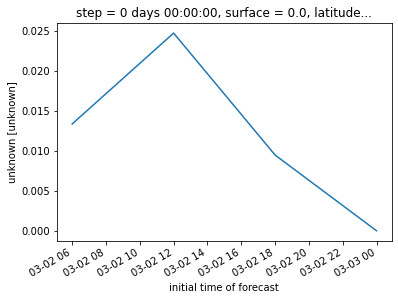

In [25]:
ds['precip'][:,611,600].plot()

## Plotting

### With Matplotlib

Since xarray uses matplotlib as its backend by default, you can combine the two and make use of the full functionality of matplotlib and also cartopy as well.

First, ensure the plots are displayed inline in this notebook, plus ignore some warnings from the Shapely and Cartopy libraries.

In [26]:
%matplotlib inline

import warnings
from shapely.errors import ShapelyDeprecationWarning
from cartopy.io import DownloadWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=DownloadWarning)

First, we'll grab a new dataset, the 24-hour RDRS for yesterday.  We'll put all the parameters into a keyword argument dictionary.

In [27]:
kwargs = dict(system_name = 'RDPA', accumulation_period = 24, cutoff = '0100', vdate = yesterday, vtime = 12)
capa_R = capa_file(**kwargs)
ds_R = download_and_read_grib(capa_R.url, filter_by_keys={'stepType': 'accum'})
try:
    ds_R = ds_R.rename({"unknown" : "precip"})
except:
    pass

Now we'll plot it on a global orthographic projection to see the full spatial domain of the product.

Text(0.5, 1.0, 'RDRS spatial domain')

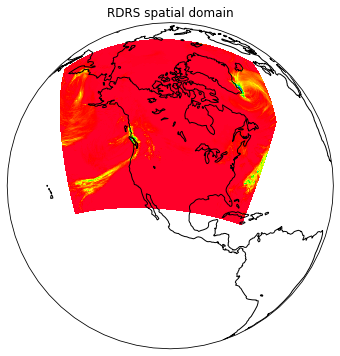

In [28]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.Orthographic(-105, 35))
ax.set_global()
cmap = plt.cm.gist_rainbow
ds_R["precip"].plot.pcolormesh(ax=ax, x='longitude', y='latitude', 
                                transform=ccrs.PlateCarree(), 
                                cmap=cmap, add_colorbar=False, shading='auto')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAKES, facecolor='none', edgecolor='black')
ax.set_title(f"RDRS spatial domain")

We can also compare the RDPA to the HRDPA.

Here we'll simply swap the system name in the keyword arguments dictionary we created.

In [29]:
kwargs['system_name'] = 'HRDPA'
capa_HR = capa_file(**kwargs)
ds_HR = download_and_read_grib(capa_HR.url, filter_by_keys={'stepType': 'accum'})
try:
    ds_HR = ds_HR.rename({"unknown" : "precip"})
except:
    pass

Now we'll create two subplots to compare the domains of each system.

Text(0.5, 1.0, 'HRDPA spatial domain')

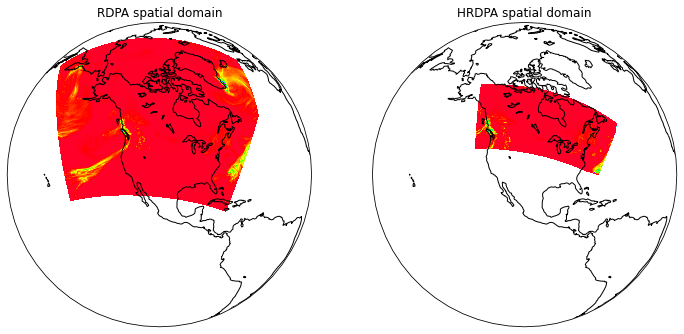

In [30]:
# create one figure with two axes, one for RDPA, the other for HRDPA
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': ccrs.Orthographic(-105, 35)}, figsize=(12,6))

cmap = plt.cm.gist_rainbow
map_kwargs = dict(transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, shading='auto')

# RDPA
ax1.set_global()
ds_R["precip"].plot.pcolormesh(ax=ax1, x='longitude', y='latitude', **map_kwargs)                           
ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.LAKES, facecolor='none', edgecolor='black')
ax1.set_title(f"RDPA spatial domain")

# HRDPA
ax2.set_global()
ds_HR["precip"].plot.pcolormesh(ax=ax2, x='longitude', y='latitude', **map_kwargs)
ax2.add_feature(cf.COASTLINE)
ax2.add_feature(cf.LAKES, facecolor='none', edgecolor='black')
ax2.set_title(f"HRDPA spatial domain")

The RDPA system covers most of North America, while HRDPA covers most of Canada plus some boundary areas of the US.

We can look much closer at the data by zooming in to look at a smaller area of course, but first, we'll create a function to make the map a bit more interesting.

In [31]:
def plot_map(ds, variable, vdatetime=None, **kwargs):
    
    if vdatetime is None:
        layer = ds[f'{variable}']
    else:
        layer = ds[f'{variable}'].loc[vdatetime,:,:]
    
    plot_title = variable if 'title' not in kwargs.keys() else kwargs['title']
    plot_label = variable if 'label' not in kwargs.keys() else kwargs['label']
    
    min_precip = 0
    max_precip = 100
    interval = 10

    levels = [0.1, 0.5, 1, 2.5, 5, 10, 15, 20, 25] + list(range(30, max_precip+interval, interval))
    ticks = levels.copy()
    cmap = plt.get_cmap("turbo").copy()
    cmap.set_over("maroon")
    cmap.set_under("#ececec")
    
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    x = layer['longitude']
    y = layer['latitude']
    
    p = ax.pcolormesh(x, y, layer, 
                      transform=ccrs.PlateCarree(), 
                      cmap=cmap, norm=mcolors.BoundaryNorm(levels, ncolors=256, extend='both'), 
                      label='none', shading='auto')
    
    if 'bbox' in kwargs.keys(): # else full extent of layer is plotted
        bbox = kwargs['bbox']
        west = bbox['west']
        south = bbox['south']
        east = bbox['east']
        north = bbox['north']
        ax.set_extent([west, east, south, north])
        
    fig.tight_layout(pad=2)

    # features
    edgecolor = 'black'
    lakes_hr = cf.NaturalEarthFeature(
            category='cultural',
            name='admin_0_countries_lakes',
            scale='10m',
            edgecolor=edgecolor,
            facecolor='none')
    borders = cf.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            edgecolor=edgecolor,
            facecolor='none')

    ax.add_feature(cf.LAND, edgecolor=edgecolor)
    ax.add_feature(cf.COASTLINE, edgecolor=edgecolor)
    ax.add_feature(lakes_hr)
    ax.add_feature(borders, linestyle='dashed')
    
    # add colorbar as separate axis and make it the right size
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cb = plt.colorbar(p, cax=cax, ticks=ticks, label=label)
    cb.ax.set_yticklabels(["{:.0f}".format(i) if i >= 1 else "{:.1f}".format(i) for i in cb.get_ticks()])
 
    ax.set_title(title)
    
    return ax

Now we can give it a try.  We can use either system and different bounding boxes.  Different variables even, though currently we only have the variable 'precip' in our dataset.

<GeoAxesSubplot:title={'center':'RDPA 10-km : 6-hr Total Precipitation, Valid at 2022-03-02T12:00:00 UTC'}>

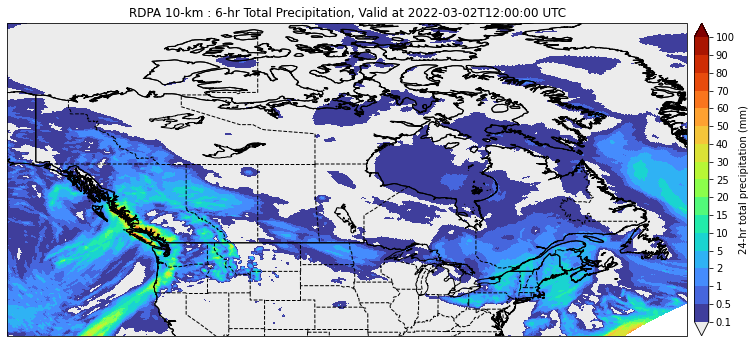

In [32]:
variable = 'precip'

title = f'RDPA 10-km : 6-hr Total Precipitation, Valid at {vdatetime} UTC'
label='24-hr total precipitation (mm)'

# Canada
bbox = dict(north = 75, south = 36, east = -50, west = -145)

plot_map(ds_R, variable, vdatetime=None, title=title, label=label, bbox=bbox)

<GeoAxesSubplot:title={'center':'HRDPA 2.5-km : 24-hr Total Precipitation, Valid at 2022-03-02T12:00:00 UTC'}>

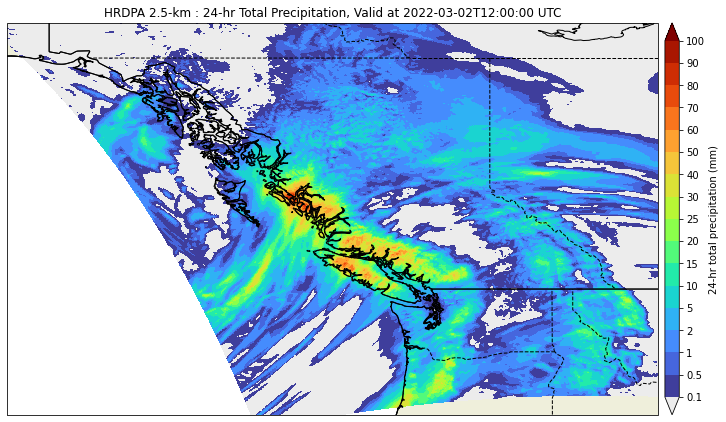

In [33]:
variable = 'precip'

title = f'HRDPA 2.5-km : 24-hr Total Precipitation, Valid at {vdatetime} UTC'
label='24-hr total precipitation (mm)'

# BC
bbox = dict(north = 61, south = 43, east = -112, west = -143)

plot_map(ds_HR, variable, vdatetime=None, title=title, label=label, bbox=bbox)

<GeoAxesSubplot:title={'center':'HRDPA 2.5-km : 24-hr Total Precipitation, Valid at 2022-03-02T12:00:00 UTC'}>

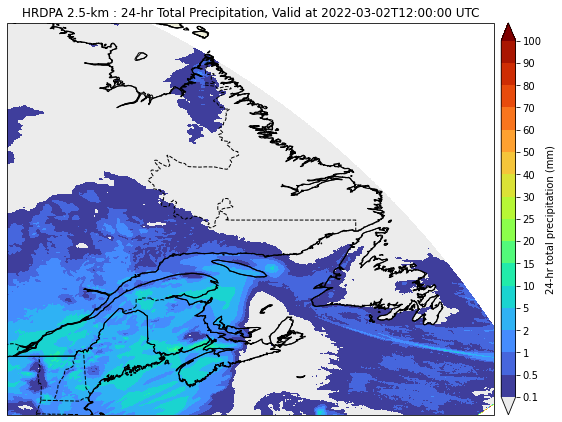

In [34]:
# Atlantic Canada
bbox= dict(north = 62, south = 42, east = -50, west = -75)

plot_map(ds_HR, variable, vdatetime=None, title=title, label=label, bbox=bbox)